## Libraries

In [2]:
library(tidyverse)
library(gridExtra)
library(jsonlite)
library(lubridate)

── Attaching packages ───────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ──────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




## Data loading

This is our working directory:

In [3]:
d_data <- "../../app/public/data/ebird/"

### Method

The eBird data can be loaded in two ways:
- From a CSV file, which can be created with `export.r`
- From a (filtered) EBD file, which can be created with `filter.r`

The CSV method is much faster, as most columns have been removed. Use the original EBD method if you need those columns.

#### CSV method

In [4]:
read_ebd_csv <- function (filename) {
    read.csv(
        paste0(d_data, filename),
        header = FALSE, 
        col.names = c("date", "lat", "lon", "count")
    ) %>%
    # convert numbers to dates
    mutate(
        date = as_date(date)
    ) %>%
    return
}

#### EBD method

In [5]:
# commented out since it is unused

# library(auk)

# read_ebd_auk <- function (filename) {
#     # read the ebd file (can take a while, don't run on full 300GB dataset)
#     paste0(d_data, filename) %>% read_ebd %>% return
# }

### Species

#### Barn Swallow

In [6]:
ebd_raw <- read_ebd_csv("ebd_barswa_1950_2020.csv")

## Data preprocessing

Observations with a count of 1000 or more are removed.

In [7]:
ebd <- ebd_raw %>% filter(count < 1000)

## Data analysis

### How many outliers are there?

In [8]:
ebd_raw %>% arrange(desc(count)) %>% head(n=20)

,date,lat,lon,count
,<date>,<dbl>,<dbl>,<int>
1,2020-09-19,40.67170,0.8208510,500000
2,1998-09-19,50.91673,0.9644487,100000
3,1999-09-25,50.91673,0.9644487,50000
4,2020-09-17,40.65905,0.6948075,50000
5,1996-09-15,50.91673,0.9644487,35000
6,2017-05-06,51.40556,3.5284057,34925
7,2001-09-25,43.37361,28.4645462,30000
8,1977-10-04,40.19353,27.9617491,25000
9,1996-09-25,50.91673,0.9644487,25000


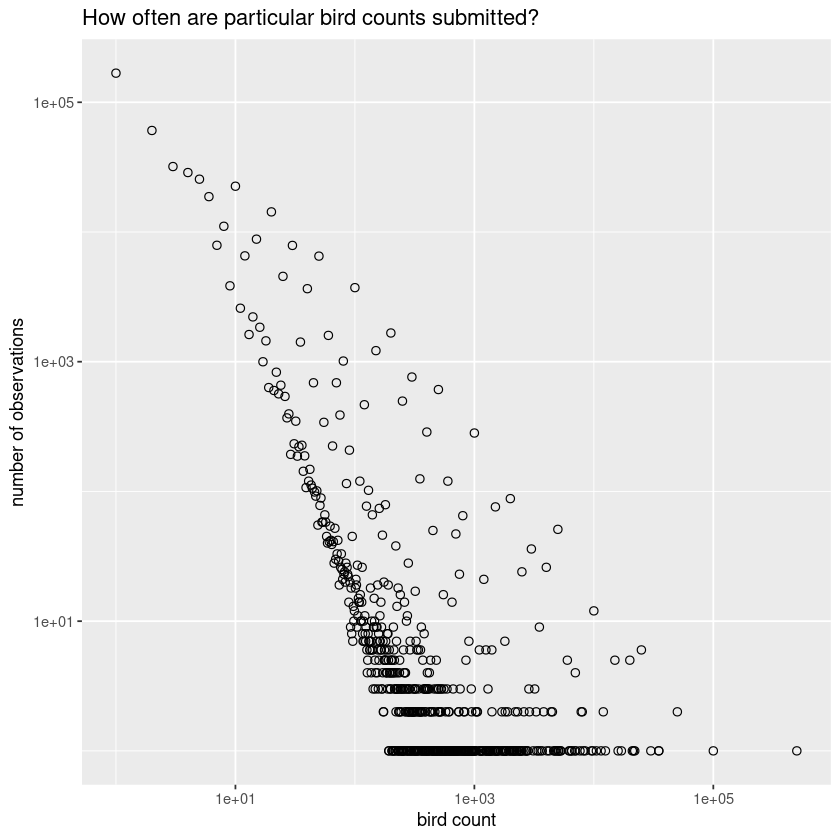

In [9]:
count_summary <- ebd_raw %>%
    transmute(bird_count = count) %>% 
    group_by(bird_count) %>%
    summarize(observation_count = n(), .groups="drop")

ggplot(count_summary, aes(x=bird_count, y=observation_count)) + 
    geom_point(shape=1, size=2) +
    scale_x_log10() +
    scale_y_log10() +
    labs(title="How often are particular bird counts submitted?", x="bird count", y="number of observations")

In [29]:
outliers <- ebd_raw %>% filter(count >= 1000) %>% arrange(desc(count))

nrow(outliers)
nrow(ebd)

sum(outliers$count)
sum(ebd$count)

[1] 837

[1] 468548

[1] 3058269

[1] 5745416

### How do observations change depending on time and place on Earth?

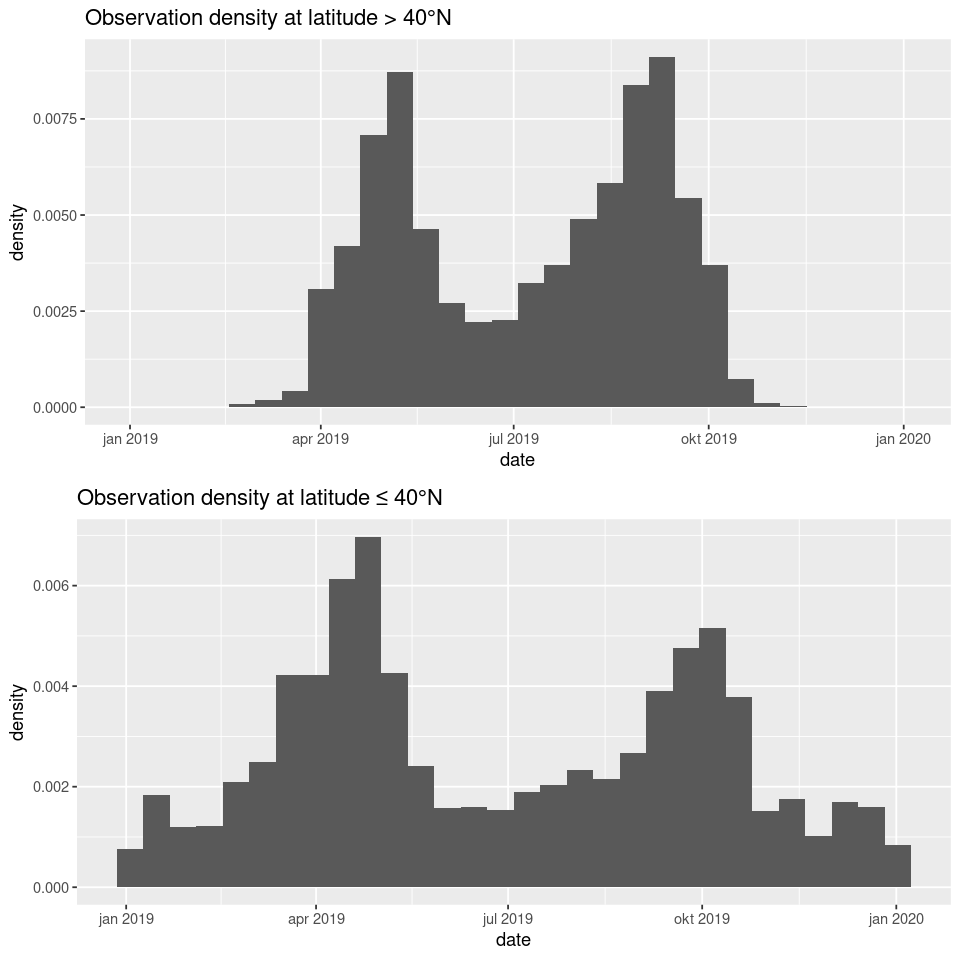

In [30]:
ebd_2019 <- ebd %>% filter(year(date) == 2019)

ebd_north <- ebd_2019 %>%
    filter(lat > 40) %>%
    group_by(date) %>%
    summarize(count_day_sum = sum(count), .groups="drop")

ebd_south <- ebd_2019 %>%
    filter(lat <= 40) %>%
    group_by(date) %>%
    summarize(count_day_sum = sum(count), .groups="drop")

plot_north <- ggplot(ebd_north) +
    geom_histogram(aes(x=date, y=..density.., weight=count_day_sum), bins=30) +
    labs(title="Observation density at latitude > 40°N")

plot_south <- ggplot(ebd_south) +
    geom_histogram(aes(x=date, y=..density.., weight=count_day_sum), bins=30) +
    labs(title="Observation density at latitude ≤ 40°N")

options(repr.plot.width=8, repr.plot.height=8)
grid.arrange(plot_north, plot_south)

### How do the observation counts change over time?

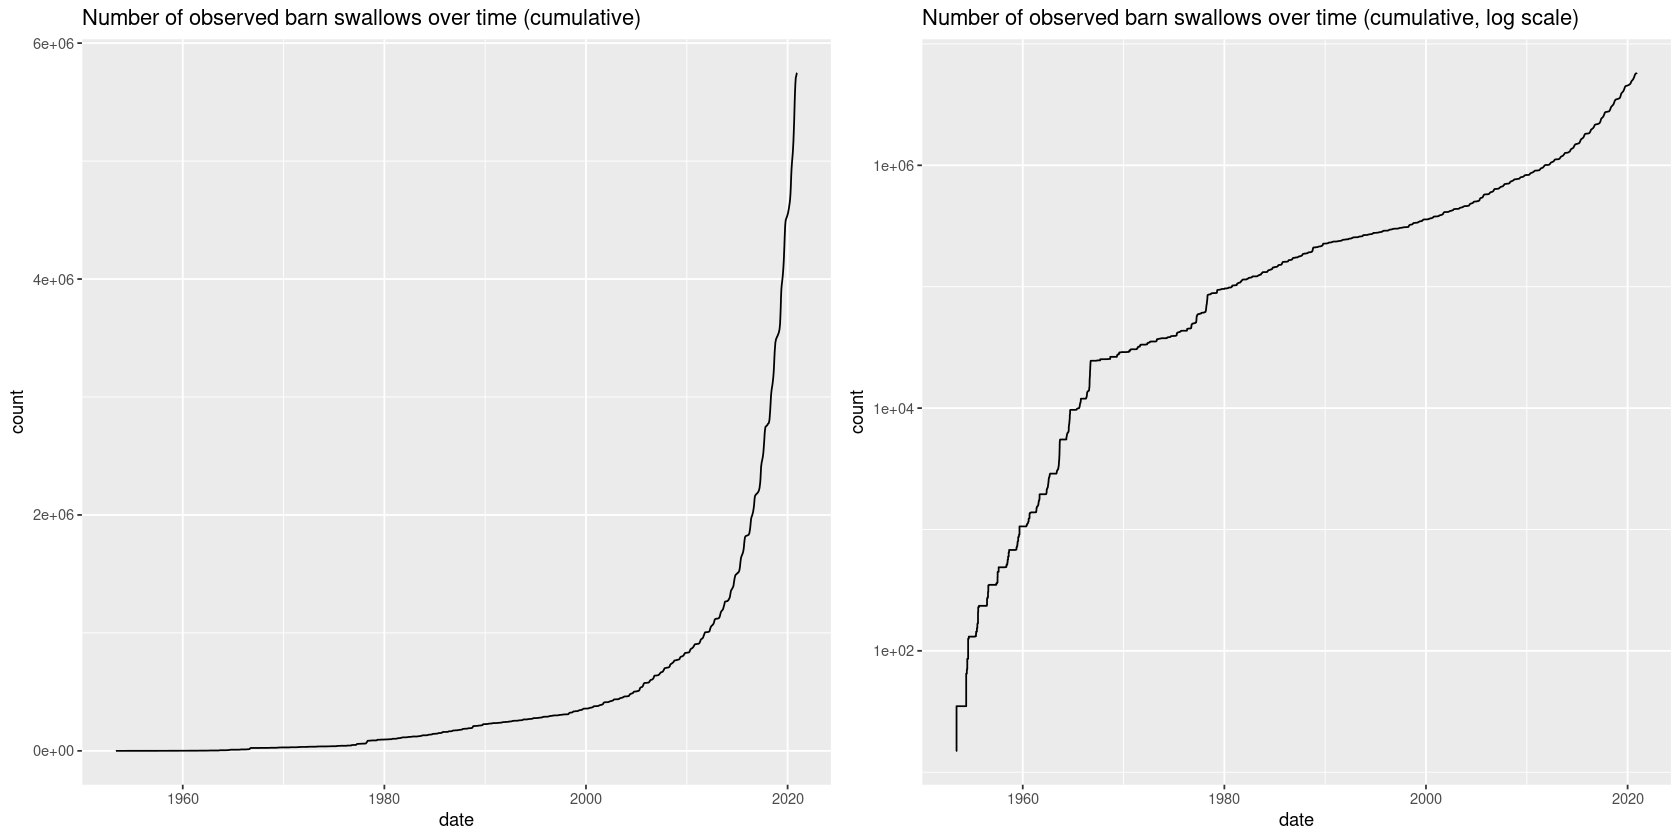

In [31]:
ebd_acc <- ebd %>%
    arrange(date) %>%
    mutate(
        count_acc = accumulate(count, `+`)
    )

plot_linear <- ggplot(ebd_acc) +
    geom_step(aes(x=date, y=count_acc)) +
    ylab("count") +
    labs(title="Number of observed barn swallows over time (cumulative)")

plot_log <- plot_linear + 
    scale_y_log10() +
    labs(title="Number of observed barn swallows over time (cumulative, log scale)")

options(repr.plot.width=14, repr.plot.height=7)
grid.arrange(plot_linear, plot_log, ncol=2)

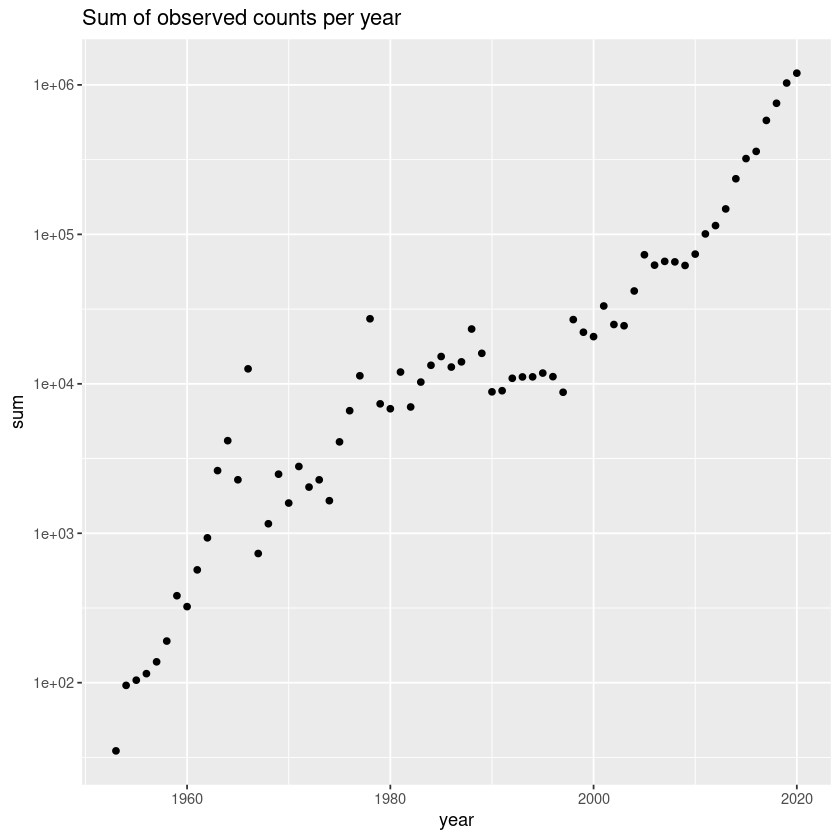

In [36]:
ebd_month_sum <- ebd %>%
    mutate(
        year = floor_date(date, unit="year")
    ) %>%
    group_by(year) %>%
    summarize(sum = sum(count), .groups="drop") %>%
    arrange(desc(sum))

options(repr.plot.width=7, repr.plot.height=7)
ggplot(ebd_month_sum, aes(x=year, y=sum)) + 
    scale_y_log10() + 
    geom_point() +
    labs(title="Sum of observed counts per year")

### Generating a grid

In [33]:
# compute monthly count totals needed to compute monthly frequency
month_summary <- ebd %>%
    mutate(
        month = floor_date(date, unit="month"),
    ) %>%
    select(month, count) %>%
    group_by(month) %>%
    summarize(month_count = sum(count), .groups="drop")

glimpse(month_summary)

Rows: 697
Columns: 2
$ month       <date> 1953-05-01, 1953-06-01, 1954-05-01, 1954-06-01, 1954-07-…
$ month_count <int> 15, 20, 30, 6, 15, 45, 1, 12, 10, 55, 26, 34, 37, 44, 10,…


In [34]:
# generate grid of monthly frequencies
grid <- ebd %>%
    mutate(
        month = floor_date(date, unit="month"),
        lat_round = floor(lat),
        lon_round = floor(lon)
    ) %>%
    # sum counts for all rows with the same month, lat and lon
    group_by(month, lat_round, lon_round) %>%
    summarize(cell_count = sum(count), .groups="drop") %>%
    # compute monthly frequency for each cell
    inner_join(month_summary, by="month") %>%
    mutate(
        # compute cell count relative to monthly count total
        frequency = cell_count / month_count
    ) %>%
    # scale frequency to [0,1] for each month
    group_by(month) %>%
    mutate(frequency = frequency / max(frequency)) %>%
    ungroup()

head(grid, n=20)

month,lat_round,lon_round,cell_count,month_count,frequency
<date>,<dbl>,<dbl>,<int>,<int>,<dbl>
1953-05-01,59,16,15,15,1.00000000
1953-06-01,59,16,20,20,1.00000000
1954-05-01,59,16,30,30,1.00000000
1954-06-01,59,16,6,6,1.00000000
1954-07-01,59,16,15,15,1.00000000
1954-08-01,58,16,5,45,0.12500000
1954-08-01,59,16,40,45,1.00000000
1955-04-01,45,12,1,1,1.00000000
1955-05-01,58,16,12,12,1.00000000


### How does migration behavior change over time?

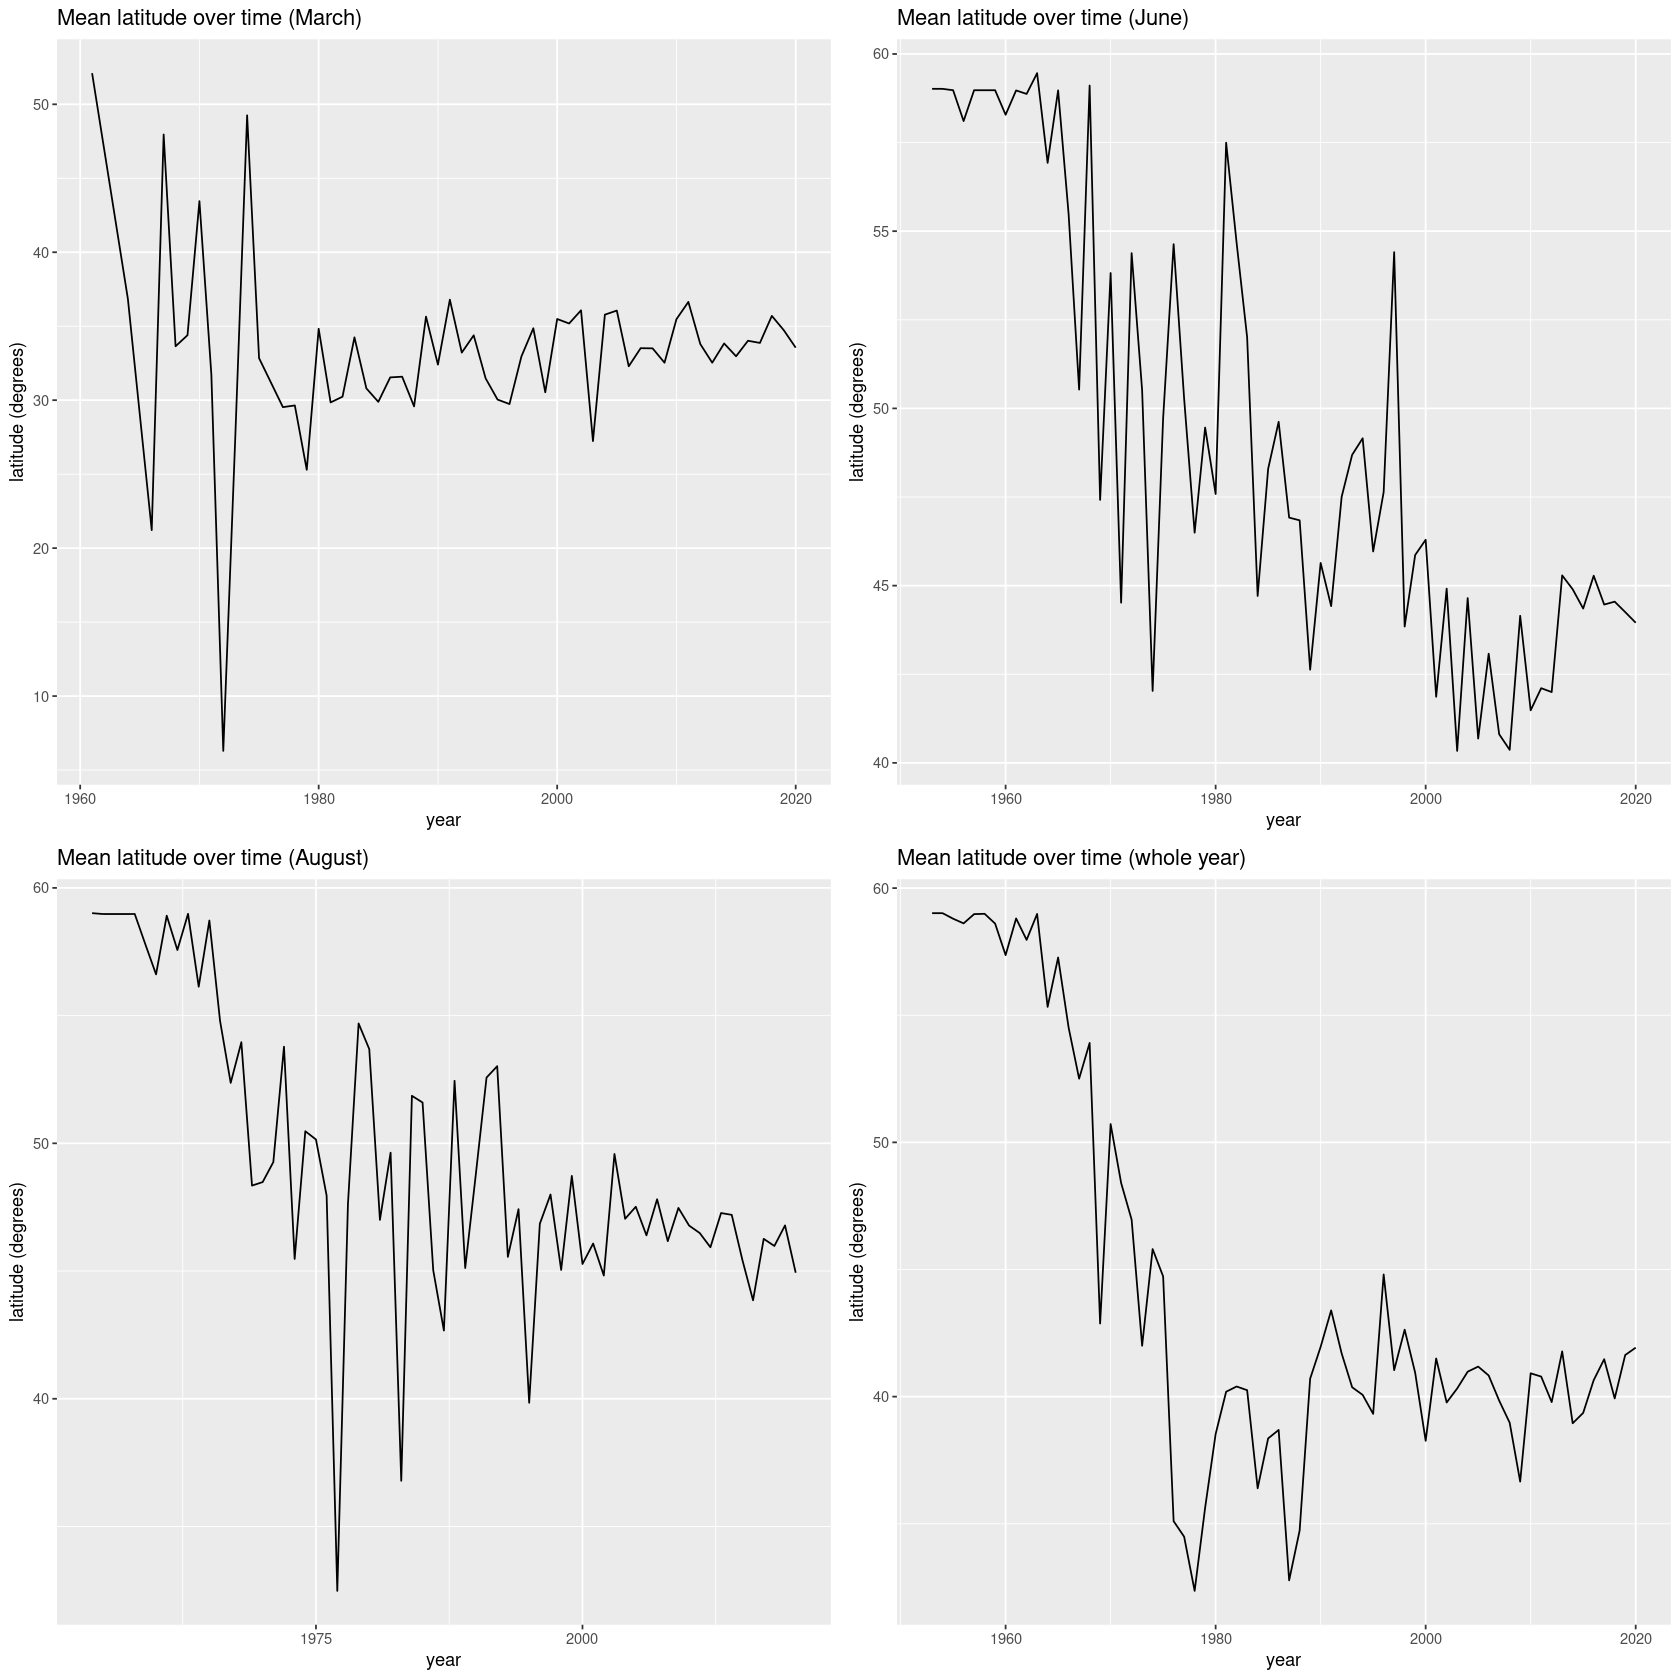

In [35]:
plot_month <- function (month) {
    ebd_mean_lat <- ebd %>%
        filter(month(date) == month) %>%
        group_by(year = year(date)) %>%
        summarize(mean_lat = weighted.mean(lat, count), .groups="drop")
    
    plot <- ggplot(ebd_mean_lat) + 
        geom_line(aes(x=year, y=mean_lat)) +
        labs(x="year", y="latitude (degrees)", title=paste0("Mean latitude over time (", month.name[month], ")"))
    
    return(plot)
}

plot_whole_year <- function () {
    ebd_mean_lat <- ebd %>%
        group_by(year = year(date)) %>%
        summarize(mean_lat = weighted.mean(lat, count), .groups="drop")
    
    plot <- ggplot(ebd_mean_lat) + 
        geom_line(aes(x=year, y=mean_lat)) +
        labs(x="year", y="latitude (degrees)", title="Mean latitude over time (whole year)")
    
    return(plot)
}

options(repr.plot.width=14, repr.plot.height=14)
grid.arrange(plot_month(3), plot_month(6), plot_month(8), plot_whole_year(), ncol=2, nrow=2)